In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Introduction to AI and OpenVino

## Session 07a - Dimensionality Reduction

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
import sys
import os
from time import time
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import matplotlib.patheffects as PathEffects

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 7),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1,
          'scatter.edgecolors': 'b' # edge color of markers
         }

CMAP = plt.cm.brg
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE = 0.2

<Figure size 1500x700 with 0 Axes>

In [4]:
 # Utility function to visualize the outputs of PCA and t-SNE

def digit_scatter(x, labels):
    '''
    Args:
        x: (dimentional data)
        labels : labels of the data
    Returns:
        
    
    '''
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    fig, ax = plt.subplots(figsize=(6, 6))
    
    #ax = plt.subplot(aspect='equal')
    ax.set_aspect('auto')
    
    sc = ax.scatter(x[:,0], x[:,1], s=15, 
                    c=palette[labels.astype(np.int16)], 
                    edgecolors = 'k')
    
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[labels == i, :], axis=0)
        
        txt = ax.text(xtext, ytext, str(i), fontsize=20)
        
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        
        txts.append(txt)

    return

## The Curse of Dimensionality

Handling the high-dimensional data is very difficult in practice, commonly known as the *curse of dimensionality*. If the dimensionality of the input dataset increases, any machine learning algorithm and model becomes more complex. Hence, first motivation can be called **Data Compression**.

As the number of features increases, the number of samples also gets increased proportionally, and the chance of over-fitting also increases. If the machine learning model is trained on high-dimensional data, it becomes over-fitted and results in poor performance.

Hence, it is often required to reduce the number of features, which can be done with dimensionality reduction. Second motivation can be said as **Avoid Over-fitting**.

We usually collect data from a variety of sources and some of the sources are reporting similar data in different format e.g. rain fall in inches vs that in cms.

There is a bright possibility that we may have similar data in a number of columns and hence redundant features. In a practice, we reduce 1000 features to somewhere close to 100.

Third motivation is assistance in **Data Visualization**. 

## Dimensionality Reduction

### PCA

For further details, please refer http://scikit-learn.org/


<img src='../../images/S04_fig1.png' width='400' alt="PCA Image"/>



The first principal component is the direction of maximum variance in the data. The second principal component is the direction of maximum variance in the space perpendicular (orthogonal) to the first principal component and so on and so forth. The first and second principal components the 2D data are shown above.

We also learned that the first principal component is the $eigenvector$ of the covariance matrix corresponding to the maximum $eigenvalue$. 

The second principal component is the $eigenvector$ corresponding to the second largest $eigenvalue$.

In [5]:
# CSV file name
iris_file = os.path.join(inpDir, moduleDir, 'iris.csv')

# Define feature names

iris_features = ['sepal length',
                 'sepal width',
                 'petal length',
                 'petal width',
                 'target']
# Read the CSV file
iris_df = pd.read_csv(iris_file, sep=',', 
                      skiprows=1, header=None, 
                      names = iris_features)

In [6]:
iris_df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [7]:
features = iris_df.drop('target',axis=1).to_numpy()
labels = iris_df['target']

num_classes = np.unique(labels)

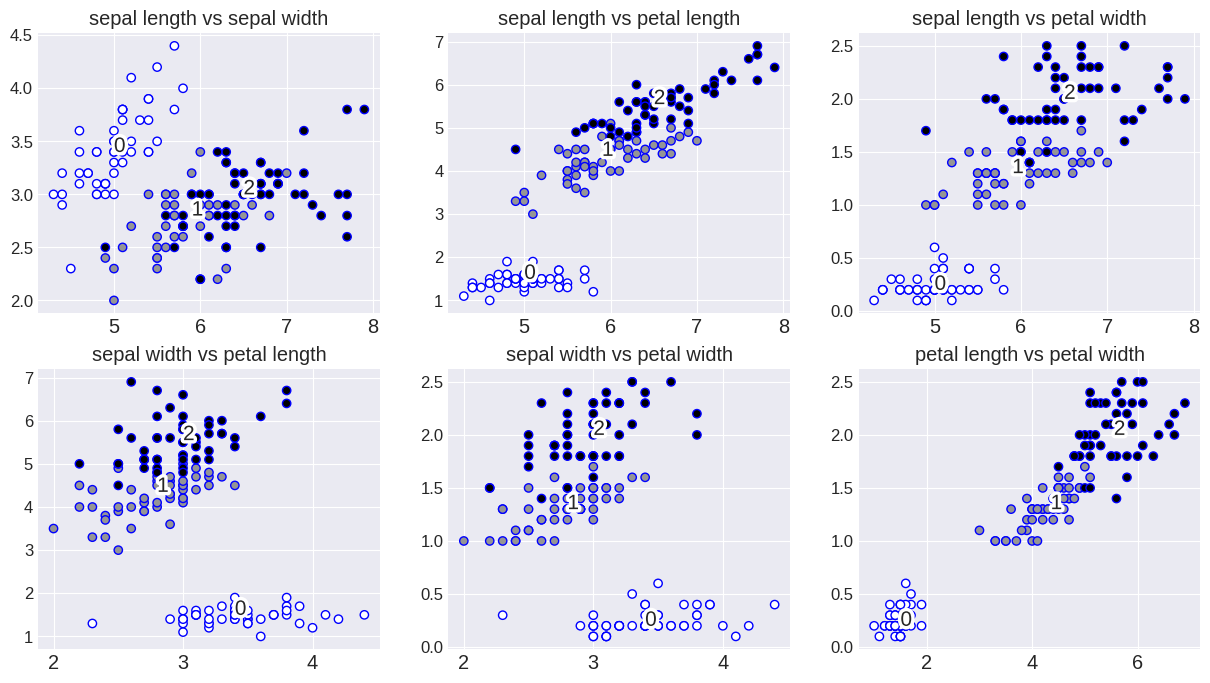

In [8]:
# Plot the features
kk = 1
plt.figure( figsize = (15 , 8) )
for ii in range (features.shape[1]-1):
    for jj in range (ii+1, (features.shape[1])):
        ax = plt.subplot(2, 3, kk )
        kk += 1
        ax.scatter( features [ :, ii], features [ :, jj], c = labels)
        for i in num_classes:
            # Position of each label at median of data points.
            xtext = np.median(features[labels == i, ii], axis=0)
            ytext = np.median(features[labels == i, jj], axis=0)
            txt = ax.text(xtext, ytext, str(i), fontsize=15)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])
        ax.set_title('{} vs {}'.format(iris_features[ii], 
                                       iris_features[jj]))
        ax.axis('tight')

plt.show()

Probably **Petal Length** *vs.* **Petal Width** gives us best separation. But only after looking at all the features. Can this be automated? Let's try PCA!

Using PCA we can summarize instance with less features. PCA is not selecting some features and discarding the others. Instead, it constructs *'some new'* features to summarize labels. In fact, PCA finds the best possible features, the ones that summarize the labels. PCA looks for features that allow to reconstruct the original features.

Before doing any PCA it is important to first **Standardize** the data.

Standard scaler calculates as follows:
$z = \frac{(x_i - \mu)}{\sigma}$

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

## PCA Calculation Steps
1. Calculate Covariance Matrix = $\frac{1}{m} \circ \sum_{i=1}^n x^i \circ (x^i)^T$
2. Compute eigenvectors of Covariance Matrix : [U, S, V] = svd(Covariance Matrix) where **svd** is `Single Value Decomposition`. Outputs are three matrices. Matrix U is of importance to us and U is n x n matrix.
   In order to reduce dimensions from n to k, take first k values from the U matrix. Lets call it $U_{reduced}$
3. Calculate reduced values with K dimensions: $Z = U_{reduced}^T \circ X$.
   Note: $U_{reduced}$ is n x k matrix and x is n x m and hence the Z becomes k x m matrix

for some reason if you need to un-compress the data, we can use: $X = U_{reduced} \circ Z$.
   Note: $U_{reduced}$ is n x k matrix and Z is k x m and hence the X becomes n x m matrix 

In [10]:
# instantiate PCA
pca = PCA(n_components=2) # reducing them to two features

# fit PCA using the features
pca.fit(X_scaled)

PCA(n_components=2)

In [11]:
#Principal axis in feature space, representing the directions of maximum variance in the data.
pca.components_

array([[ 0.52237162, -0.26335492,  0.58125401,  0.56561105],
       [ 0.37231836,  0.92555649,  0.02109478,  0.06541577]])

In [12]:
#Percentage of variance explained by each of the selected components.
pca.explained_variance_ratio_

array([0.72770452, 0.23030523])

In [13]:
pca.explained_variance_ratio_.sum()

0.9580097536148197

In general, its advisable to keep explained variance more than 0.95!

Explained variance comes from SVD analysis and Matrix S helps us in calculating the explained variance.

[U, S, V] = svd(Covariance Matrix)

S is a diagonal matrix.

$
\begin{aligned}
S &= \begin{bmatrix}s_1^{(1)}  & 0 & 0 & ... & 0\\ 
0 & s_2^{(2)} & 0 & ... & 0\\
0 & 0 & s_3^{3}& ... & 0\\
0 & 0 & 0 & ... & s_n^{(n)} \end{bmatrix}\\
\text{sum of explained variance} = \frac{\sum_{i=1}^k s_{i,i}}{\sum_{i=1}^n s_{i,i}}
\end{aligned}
$

Hence run SVD once and select value of K such that sum of explained variance > 0.95 or whatever value you need.

In [14]:
#Having fitted the pca we also need to transform...
X_pca = pca.transform(X_scaled)

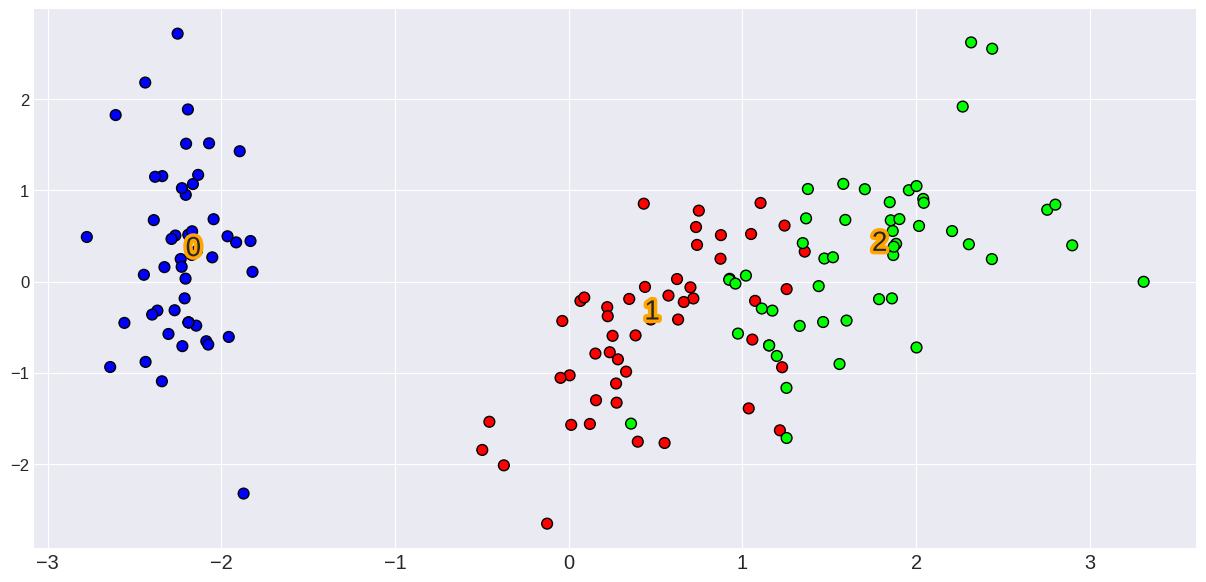

In [15]:
# how it looks?
figure, ax = plt.subplots( )
ax.scatter( X_pca [ :, 0], X_pca [ :, 1], s = 60, c = labels, cmap = CMAP, ec = 'k')

for i in num_classes:
    
    # Position of each label at median of data points.
    
    xtext = np.median(X_pca[labels == i, 0], axis=0)
    
    ytext = np.median(X_pca[labels == i, 1], axis=0)
    
    txt = ax.text(xtext, ytext, str(i), fontsize=20)
    
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=5, foreground="Orange"),
        PathEffects.Normal()])
    
plt.show()

In [16]:
#so where is this data centered around?

print ("Mean = {:s}\n".format(str(np.round(X_pca.mean(axis=0), decimals=5))))

print ("Standard Deviation = {:s}\n".format(str(np.round(X_pca.std(axis=0), decimals=5))))

# Do they have any correlation?? 
print ("Corr Coef. = \n", (np.corrcoef(X_pca.T)))

Mean = [ 0. -0.]

Standard Deviation = [1.70611 0.9598 ]

Corr Coef. = 
 [[ 1.00000000e+00 -3.29983032e-16]
 [-3.29983032e-16  1.00000000e+00]]


### Manifold learning algorithms 
They generally do a better job in recovering the underlying 2-dimensional manifold

In [17]:
## Load Data
from sklearn.datasets import load_digits

digits = load_digits()

X, y = digits.data, digits.target

n_samples, n_features = X.shape

n_neighbors = 30


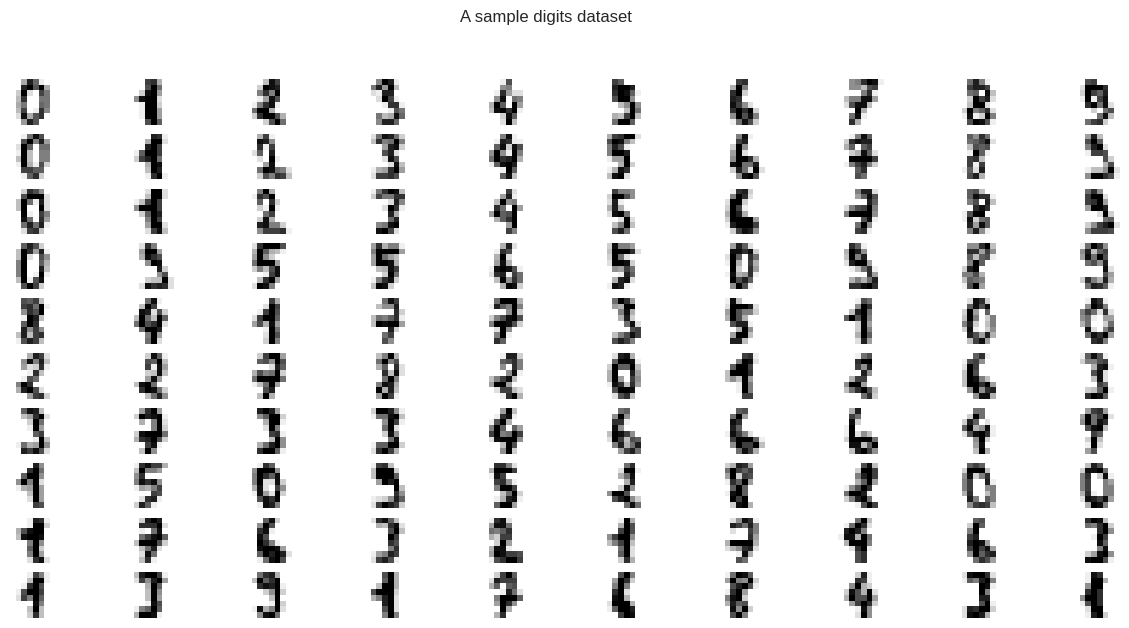

In [18]:
fig, axs = plt.subplots(nrows=10, ncols=10)

for idx, ax in enumerate(axs.ravel()):
    
    ax.imshow(X[idx].reshape((8, 8)), cmap = plt.cm.binary)
    
    ax.axis("off")

_ = fig.suptitle("A sample digits dataset")

In [19]:
sc = StandardScaler()

X_scaled = sc.fit_transform(X)

In [20]:
# first PCA
# instantiate PCA

pca = PCA(n_components=2) # reducing them to two features

projections = pca.fit_transform(X_scaled, y)

print (projections.shape)

(1797, 2)


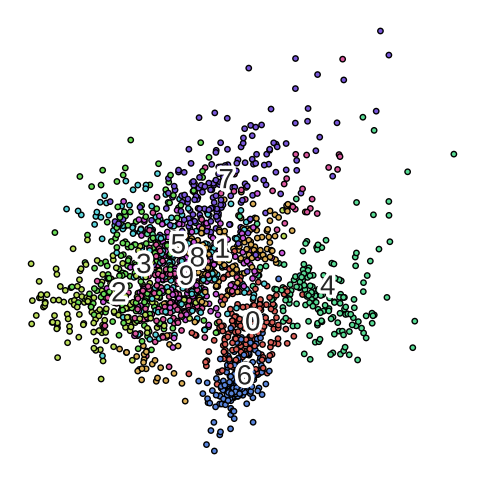

In [21]:
_ = digit_scatter(projections, y)

# Linear Discriminant Analysis embedding

Linear Discriminant analysis is one of the most popular dimensionality reduction techniques used for **supervised classification** problems in machine learning. It is also considered a pre-processing step for modeling differences in ML and applications of pattern classification.

To create a new axis, Linear Discriminant Analysis uses the following criteria:

- It maximizes the distance between means of two classes.
- It minimizes the variance within the individual class.

Using the above two conditions, LDA generates a new axis in such a way that it can maximize the distance between the means of the two classes and minimizes the variation within each class.

In other words, we can say that the new axis will increase the separation between the data points of the two classes and plot them onto the new axis.

#### Extension to Linear Discriminant Analysis (LDA)

It has so many extensions and variations as follows:

- Quadratic Discriminant Analysis (QDA): For multiple input variables, each class deploys its own estimate of variance.
- Flexible Discriminant Analysis (FDA): it is used when there are non-linear groups of inputs are used, such as splines.

In [22]:
X_scaled.shape

(1797, 64)

In [45]:
lda = LinearDiscriminantAnalysis( n_components=2    )

data = X_scaled.copy()

data.flat[:: X_scaled.shape[1] + 1] += 0.01  # Make X invertible

projections = lda.fit_transform(data, y)

print (projections.shape)

(1797, 2)


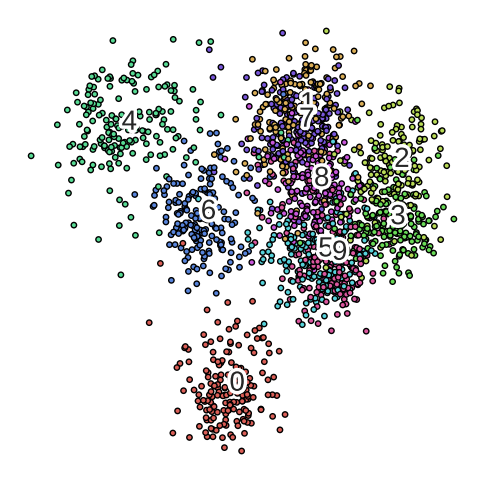

In [46]:
_ = digit_scatter(projections, y)

## PCA vs LDA

Although it might sound intuitive that LDA is superior to PCA for a multi-class classification task where the class labels are known, this might not always the case.
For example, comparisons between classification accuracies for image recognition after using PCA or LDA show that PCA tends to outperform LDA if the number of samples per class is relatively small (PCA vs. LDA, A.M. Martinez et al., 2001)